# 🔍 Player Similarity Finder & Recommendation System
## Big 5 European Leagues – Machine Learning for Football Scouting

---

### 🎯 Propósito del Notebook

Este notebook implementa un **sistema de recomendación avanzado** que:

- Encuentra jugadores similares basándose en sus estadísticas y estilo de juego
- Utiliza **K-Nearest Neighbors (KNN)** con distancia euclidiana normalizada
- Genera comparativas automáticas entre perfiles de jugadores
- Proporciona "scouting reports" basados en datos

### 📌 Casos de uso:
- 🔎 "Encuentra jugadores similares a Haaland"
- 📊 "¿Quién juega parecido a Mbappé pero con mejor progresión defensiva?"
- 🎯 "Alternativas económicas para un mediocampista creativo"
- 📈 "Jugadores emergentes con perfil parecido a estrellas consolidadas"

---

In [12]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (13, 6)
plt.rcParams['font.size'] = 11

# Cargar dataset con clusters desde el notebook anterior
df = pd.read_csv("../data/processed/players_with_clusters_k6.csv")

print(f"✅ Dataset cargado: {len(df)} jugadores únicos")
print(f"📊 Columnas: {df.shape[1]}")
df.head()

✅ Dataset cargado: 2702 jugadores únicos
📊 Columnas: 33


,Player,Min,90s,Age,Gls,Ast,G+A,G-PK,PK,PKatt,...,xAG_per90,xG+xAG_per90,npxG_per90,npxG+xAG_per90,Nation,Pos,Comp,Squad,Cluster_KMeans,DBSCAN_Label
0,Aaron Ciammaglichella,1.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,ITA,MF,Serie A,Torino,2,0
1,Aaron Cresswell,824.0,9.2,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.15,0.17,0.03,0.17,ENG,DF,Premier League,West Ham,2,0
2,Aaron Malouda,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,FRA,FW,Ligue 1,Lille,2,0
3,Aaron Ramsdale,2700.0,30.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,ENG,GK,Premier League,Southampton,2,0
4,Aaron Wan-Bissaka,3154.0,35.0,26.0,2.0,5.0,7.0,2.0,0.0,0.0,...,0.10,0.14,0.03,0.14,COD,DF,Premier League,West Ham,5,0


---
## 1. Preparación del Sistema de Recomendación

### ¿Cómo funciona?

1. **Estandarización**: Normalizamos todas las métricas para que tengan el mismo peso
2. **Matriz de similitud**: Calculamos la distancia euclidiana entre todos los jugadores
3. **K-NN Search**: Para cada jugador, encontramos los K jugadores más cercanos
4. **Interpretación**: Explicamos qué hace similares a estos jugadores

### Variables utilizadas:
- Métricas ofensivas: Gls_per90, Ast_per90, G+A_per90
- Expected metrics: xG_per90, xAG_per90, npxG_per90
- Progresión: PrgC, PrgP, PrgR
- Contexto: Age, CrdY, CrdR
---

In [13]:
# Features para el cálculo de similitud (mismo conjunto del clustering)
similarity_features = [
    'Gls_per90', 'Ast_per90', 'G+A_per90', 'xG_per90', 'xAG_per90', 'npxG_per90',
    'PrgC', 'PrgP', 'PrgR', 'CrdY', 'CrdR', 'Age'
]

# Extraer matriz de features
X_similarity = df[similarity_features].fillna(0).values

# Estandarizar (mismo scaler que en clustering, idealmente reutilizable)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_similarity)

# Entrenar modelo KNN (11 vecinos = top 10 + el mismo jugador)
n_neighbors = 11
knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn_model.fit(X_scaled)

print(f"✅ Modelo KNN entrenado")
print(f"   Vecinos a buscar: {n_neighbors}")
print(f"   Métrica: Distancia Euclidiana")
print(f"   Features: {len(similarity_features)}")

✅ Modelo KNN entrenado
   Vecinos a buscar: 11
   Métrica: Distancia Euclidiana
   Features: 12


---
## 2. Función de búsqueda: Find Similar Players

Implementamos una función robusta y flexible que:
- Busca jugadores por nombre (case-insensitive)
- Retorna información detallada de similitud
- Permite filtros opcionales (posición, liga)
- Genera visualizaciones comparativas
---


In [14]:
def find_similar_players(
        player_name: str,
        n_similar: int = 5,
        same_position: bool = False,
        same_league: bool = False,
        verbose: bool = True
) -> tuple:
    """
    Encuentra jugadores similares basándose en su perfil estadístico.

    Args:
        player_name (str): Nombre del jugador a buscar
        n_similar (int): Número de jugadores similares a retornar (default: 5)
        same_position (bool): Si True, filtrar por misma posición
        same_league (bool): Si True, filtrar por misma liga
        verbose (bool): Si True, mostrar información detallada

    Returns:
        tuple: (jugador_referencia, DataFrame con similares, distancias)
    """

    # Buscar jugador por nombre (case-insensitive)
    player_matches = df[df['Player'].str.lower() == player_name.lower()]

    if len(player_matches) == 0:
        print(f"❌ No se encontró jugador: '{player_name}'")
        return None, None, None

    if len(player_matches) > 1:
        print(f"⚠️  Se encontraron {len(player_matches)} jugadores con ese nombre:")
        for i, (idx, row) in enumerate(player_matches.iterrows(), 1):
            print(f"   {i}. {row['Player']:30s} - {row['Squad']:20s} ({row['Comp']})")
        print("   Usando el primer resultado...\n")

    # Obtener índice del jugador
    player_idx = player_matches.index[0]
    player_ref = df.loc[player_idx]

    # Obtener vecinos más cercanos
    distances, indices = knn_model.kneighbors(X_scaled[player_idx].reshape(1, -1))
    distances = distances[0]
    indices = indices[0]

    # Excluir el jugador mismo (distancia = 0)
    similar_indices = indices[1:]
    similar_distances = distances[1:]

    # Obtener datos de jugadores similares
    similar_players = df.iloc[similar_indices].copy()
    similar_players['Distance'] = similar_distances
    similar_players['Similarity_Score'] = 100 * (1 - similar_distances / similar_distances.max())

    # Aplicar filtros opcionales
    if same_position:
        similar_players = similar_players[similar_players['Pos'] == player_ref['Pos']]

    if same_league:
        similar_players = similar_players[similar_players['Comp'] == player_ref['Comp']]

    # Tomar top N
    result = similar_players.head(n_similar)

    # Output si verbose
    if verbose:
        print(f"\n{'='*100}")
        print(f"🔍 JUGADOR REFERENCIA: {player_ref['Player'].upper()}")
        print(f"{'='*100}")
        print(f"   Equipo: {player_ref['Squad']:25s} Liga: {player_ref['Comp']}")
        print(f"   Posición: {player_ref['Pos']:15s} Edad: {player_ref['Age']:.0f} años")
        print(f"\n   📊 PERFIL ESTADÍSTICO:")
        print(f"      G+A/90: {player_ref['G+A_per90']:.3f}  |  xG/90: {player_ref['xG_per90']:.3f}  |  xAG/90: {player_ref['xAG_per90']:.3f}")
        print(f"      PrgR: {player_ref['PrgR']:.0f}  |  PrgP: {player_ref['PrgP']:.0f}  |  PrgC: {player_ref['PrgC']:.0f}")
        print(f"      Cluster: {player_ref['Cluster_KMeans']}")

    return player_ref, result, similar_distances

# Test de la función
print("✅ Función find_similar_players definida y lista para usar")

✅ Función find_similar_players definida y lista para usar


---
## 3. Ejemplos prácticos: Encontrando jugadores similares

Demostración del sistema con casos reales de la temporada 2024/2025.
---


In [15]:
print("\n" + "="*100)
print("EJEMPLO 1: Jugadores similares a ERLING HAALAND")
print("="*100)

player_ref, similar, distances = find_similar_players("Erling Haaland", n_similar=7)

if similar is not None:
    print(f"\n🎯 TOP {len(similar)} JUGADORES SIMILARES:")
    print("-"*100)
    print(f"{'#':<3} {'Jugador':<30} {'Equipo':<20} {'Liga':<15} {'G+A/90':<10} {'Similitud':<12}")
    print("-"*100)

    for i, (idx, row) in enumerate(similar.iterrows(), 1):
        print(f"{i:<3} {row['Player']:<30} {row['Squad']:<20} {row['Comp']:<15} "
              f"{row['G+A_per90']:<10.3f} {row['Similarity_Score']:<12.1f}%")


EJEMPLO 1: Jugadores similares a ERLING HAALAND

🔍 JUGADOR REFERENCIA: ERLING HAALAND
   Equipo: Manchester City           Liga: Premier League
   Posición: FW              Edad: 24 años

   📊 PERFIL ESTADÍSTICO:
      G+A/90: 0.820  |  xG/90: 0.720  |  xAG/90: 0.100
      PrgR: 124  |  PrgP: 20  |  PrgC: 24
      Cluster: 1

🎯 TOP 7 JUGADORES SIMILARES:
----------------------------------------------------------------------------------------------------
#   Jugador                        Equipo               Liga            G+A/90     Similitud   
----------------------------------------------------------------------------------------------------
1   Ermedin Demirović              Stuttgart            Bundesliga      0.780      62.8        %
2   Victor Boniface                Leverkusen           Bundesliga      0.800      42.0        %
3   Myron Boadu                    Bochum               Bundesliga      0.860      40.4        %
4   Jonathan Burkardt              Mainz 05          

In [21]:
print("\n" + "="*100)
print("EJEMPLO 2: Jugadores similares a LUKA MODRIĆ")
print("="*100)

player_ref, similar, distances = find_similar_players("Luka Modrić", n_similar=7)

if similar is not None:
    print(f"\n🎯 TOP {len(similar)} JUGADORES SIMILARES:")
    print("-"*100)
    print(f"{'#':<3} {'Jugador':<30} {'Equipo':<20} {'Liga':<15} {'G+A/90':<10} {'Similitud':<12}")
    print("-"*100)

    for i, (idx, row) in enumerate(similar.iterrows(), 1):
        print(f"{i:<3} {row['Player']:<30} {row['Squad']:<20} {row['Comp']:<15} "
              f"{row['G+A_per90']:<10.3f} {row['Similarity_Score']:<12.1f}%")


EJEMPLO 2: Jugadores similares a LUKA MODRIĆ

🔍 JUGADOR REFERENCIA: LUKA MODRIĆ
   Equipo: Real Madrid               Liga: La Liga
   Posición: MF              Edad: 38 años

   📊 PERFIL ESTADÍSTICO:
      G+A/90: 0.390  |  xG/90: 0.080  |  xAG/90: 0.340
      PrgR: 63  |  PrgP: 208  |  PrgC: 62
      Cluster: 5

🎯 TOP 7 JUGADORES SIMILARES:
----------------------------------------------------------------------------------------------------
#   Jugador                        Equipo               Liga            G+A/90     Similitud   
----------------------------------------------------------------------------------------------------
1   Rodrigo De Paul                Atlético Madrid      La Liga         0.340      30.5        %
2   Hakan Çalhanoğlu               Inter                Serie A         0.510      27.1        %
3   Henrikh Mkhitaryan             Inter                Serie A         0.190      12.8        %
4   Jonathan Clauss                Nice                 Ligue 1   

In [18]:
print("\n" + "="*100)
print("EJEMPLO 3: Jugadores similares a KYLIAN MBAPPÉ")
print("="*100)

player_ref, similar, distances = find_similar_players("Kylian Mbappé", n_similar=7)

if similar is not None:
    print(f"\n🎯 TOP {len(similar)} JUGADORES SIMILARES:")
    print("-"*100)
    print(f"{'#':<3} {'Jugador':<30} {'Equipo':<20} {'Liga':<15} {'G+A/90':<10} {'Similitud':<12}")
    print("-"*100)

    for i, (idx, row) in enumerate(similar.iterrows(), 1):
        print(f"{i:<3} {row['Player']:<30} {row['Squad']:<20} {row['Comp']:<15} "
              f"{row['G+A_per90']:<10.3f} {row['Similarity_Score']:<12.1f}%")



EJEMPLO 3: Jugadores similares a KYLIAN MBAPPÉ

🔍 JUGADOR REFERENCIA: KYLIAN MBAPPÉ
   Equipo: Real Madrid               Liga: La Liga
   Posición: FW              Edad: 25 años

   📊 PERFIL ESTADÍSTICO:
      G+A/90: 1.050  |  xG/90: 0.800  |  xAG/90: 0.240
      PrgR: 386  |  PrgP: 140  |  PrgC: 150
      Cluster: 5

🎯 TOP 7 JUGADORES SIMILARES:
----------------------------------------------------------------------------------------------------
#   Jugador                        Equipo               Liga            G+A/90     Similitud   
----------------------------------------------------------------------------------------------------
1   Mason Greenwood                Marseille            Ligue 1         0.830      16.5        %
2   Ademola Lookman                Atalanta             Serie A         0.800      12.0        %
3   Raphinha                       Barcelona            La Liga         0.860      8.6         %
4   Bradley Barcola                Paris S-G            Ligu

In [19]:
print("\n" + "="*100)
print("EJEMPLO 4: Jugadores similares a MOHAMED SALAH")
print("="*100)

player_ref, similar, distances = find_similar_players("Mohamed Salah", n_similar=7)

if similar is not None:
    print(f"\n🎯 TOP {len(similar)} JUGADORES SIMILARES:")
    print("-"*100)
    print(f"{'#':<3} {'Jugador':<30} {'Equipo':<20} {'Liga':<15} {'G+A/90':<10} {'Similitud':<12}")
    print("-"*100)

    for i, (idx, row) in enumerate(similar.iterrows(), 1):
        print(f"{i:<3} {row['Player']:<30} {row['Squad']:<20} {row['Comp']:<15} "
              f"{row['G+A_per90']:<10.3f} {row['Similarity_Score']:<12.1f}%")


EJEMPLO 4: Jugadores similares a MOHAMED SALAH

🔍 JUGADOR REFERENCIA: MOHAMED SALAH
   Equipo: Liverpool                 Liga: Premier League
   Posición: FW              Edad: 32 años

   📊 PERFIL ESTADÍSTICO:
      G+A/90: 1.250  |  xG/90: 0.670  |  xAG/90: 0.380
      PrgR: 488  |  PrgP: 144  |  PrgC: 155
      Cluster: 5

🎯 TOP 7 JUGADORES SIMILARES:
----------------------------------------------------------------------------------------------------
#   Jugador                        Equipo               Liga            G+A/90     Similitud   
----------------------------------------------------------------------------------------------------
1   Bradley Barcola                Paris S-G            Ligue 1         0.990      32.4        %
2   Michael Olise                  Bayern Munich        Bundesliga      1.040      23.8        %
3   Raphinha                       Barcelona            La Liga         0.860      20.8        %
4   Ademola Lookman                Atalanta          

In [20]:
print("\n" + "="*100)
print("EJEMPLO 5: Jugadores similares a JUDE BELLINGHAM")
print("="*100)

player_ref, similar, distances = find_similar_players("Jude Bellingham", n_similar=7)

if similar is not None:
    print(f"\n🎯 TOP {len(similar)} JUGADORES SIMILARES:")
    print("-"*100)
    print(f"{'#':<3} {'Jugador':<30} {'Equipo':<20} {'Liga':<15} {'G+A/90':<10} {'Similitud':<12}")
    print("-"*100)

    for i, (idx, row) in enumerate(similar.iterrows(), 1):
        print(f"{i:<3} {row['Player']:<30} {row['Squad']:<20} {row['Comp']:<15} "
              f"{row['G+A_per90']:<10.3f} {row['Similarity_Score']:<12.1f}%")


EJEMPLO 5: Jugadores similares a JUDE BELLINGHAM

🔍 JUGADOR REFERENCIA: JUDE BELLINGHAM
   Equipo: Real Madrid               Liga: La Liga
   Posición: MF              Edad: 21 años

   📊 PERFIL ESTADÍSTICO:
      G+A/90: 0.610  |  xG/90: 0.410  |  xAG/90: 0.140
      PrgR: 143  |  PrgP: 199  |  PrgC: 74
      Cluster: 5

🎯 TOP 7 JUGADORES SIMILARES:
----------------------------------------------------------------------------------------------------
#   Jugador                        Equipo               Liga            G+A/90     Similitud   
----------------------------------------------------------------------------------------------------
1   João Pedro                     Brighton             Premier League  0.740      16.6        %
2   Morgan Gibbs-White             Nott'ham Forest      Premier League  0.480      13.2        %
3   Declan Rice                    Arsenal              Premier League  0.350      13.0        %
4   Tijjani Reijnders              Milan                S

---
## 4. Visualizaciones avanzadas: Comparativa de perfiles

Generamos visualizaciones interactivas que muestran la similitud entre jugadores de forma intuitiva.
---


✅ Función radar_chart_comparison definida


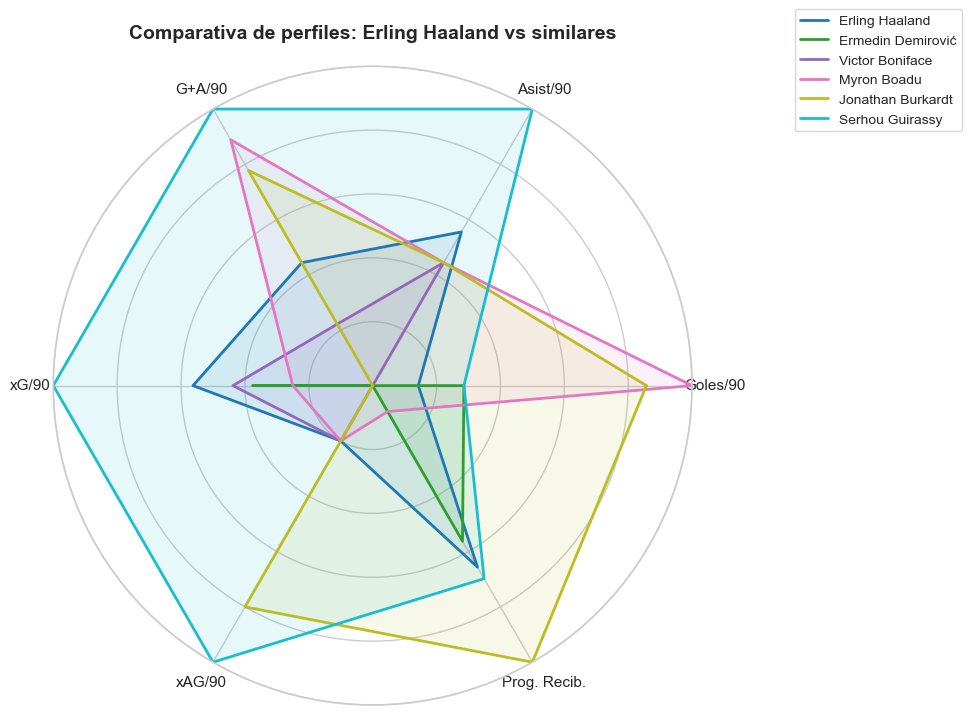

In [22]:
def radar_chart_comparison(player_name: str, n_similar: int = 5):
    """
    Crea un radar chart comparativo entre un jugador y sus similares.
    """
    player_ref, similar, _ = find_similar_players(player_name, n_similar=n_similar, verbose=False)

    if player_ref is None:
        print(f"❌ No se encontró {player_name}")
        return

    # Métricas para el radar
    metrics = ['Gls_per90', 'Ast_per90', 'G+A_per90', 'xG_per90', 'xAG_per90', 'PrgR']
    labels = ['Goles/90', 'Asist/90', 'G+A/90', 'xG/90', 'xAG/90', 'Prog. Recib.']
    n_metrics = len(metrics)

    # Recolectar datos
    all_players = pd.concat([pd.DataFrame([player_ref]), similar.head(n_similar)])
    stats = all_players[metrics].values

    # Normalización [0-1]
    stats_min = stats.min(axis=0)
    stats_range = np.ptp(stats, axis=0)  # Compatible con NumPy 2.0
    stats_norm = (stats - stats_min) / (stats_range + 1e-6)

    # Cierre del polígono
    angles = np.linspace(0, 2*np.pi, n_metrics, endpoint=False).tolist()
    stats_norm = np.concatenate([stats_norm, stats_norm[:, [0]]], axis=1)
    angles += angles[:1]

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)

    colors = plt.cm.tab10(np.linspace(0, 1, len(all_players)))

    for idx, (player_name_plot, color) in enumerate(zip(all_players['Player'], colors)):
        ax.plot(angles, stats_norm[idx], linewidth=2, label=player_name_plot, color=color)
        ax.fill(angles, stats_norm[idx], alpha=0.1, color=color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)
    ax.grid(True)

    plt.title(f"Comparativa de perfiles: {player_ref['Player']} vs similares",
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1.1), fontsize=10)
    plt.tight_layout()
    plt.show()

print("✅ Función radar_chart_comparison definida")

# Ejemplo de uso
radar_chart_comparison("Erling Haaland", n_similar=5)

---
## 5. Matriz de similitud: Heatmap de distancias

Visualizamos las distancias entre un jugador y sus similares en forma de matriz.
---


✅ Función similarity_heatmap definida


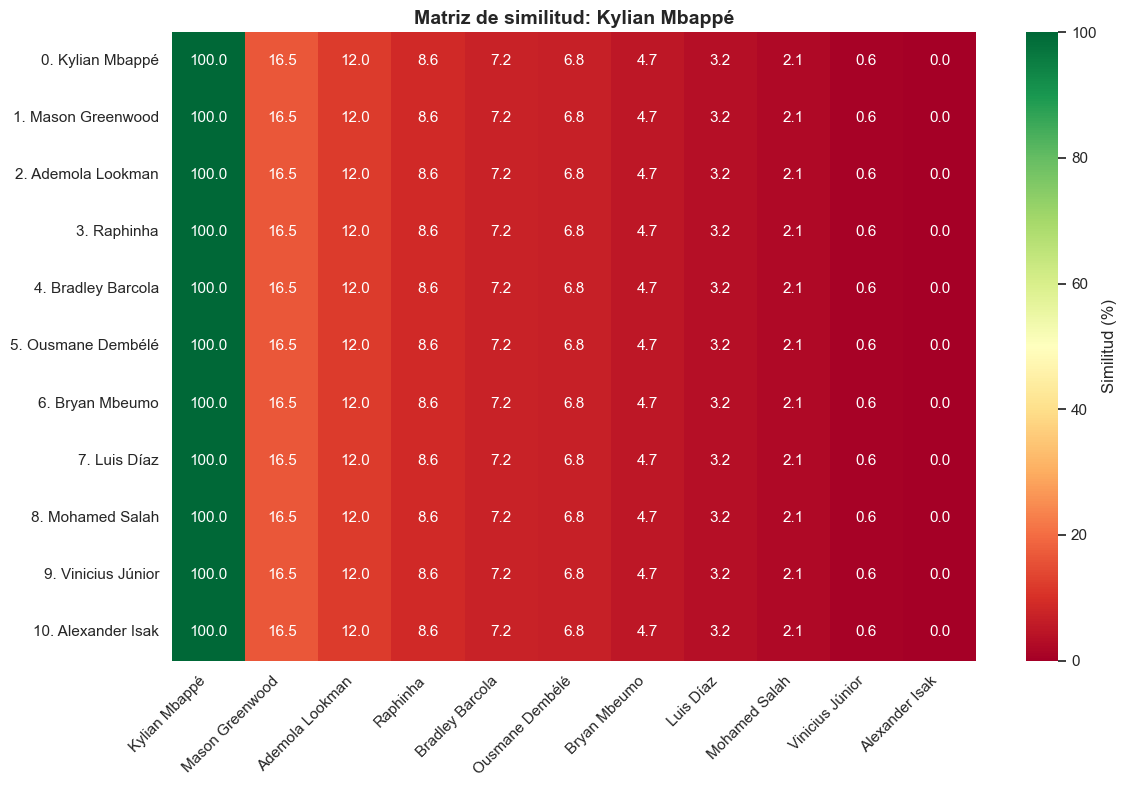

In [25]:
def similarity_heatmap(player_name: str, n_similar: int = 10):
    """
    Crea un heatmap mostrando las similitudes entre un jugador y sus similares.
    """
    player_ref, similar, distances = find_similar_players(player_name, n_similar=n_similar, verbose=False)

    if player_ref is None:
        print(f"❌ No se encontró {player_name}")
        return

    # Crear matriz de similitud
    all_players = pd.concat([pd.DataFrame([player_ref]), similar.head(n_similar)])
    player_names = all_players['Player'].values

    # Calcular similitud (convertir distancia a similitud)
    similarity_scores = all_players['Similarity_Score'].fillna(100).values
    similarity_matrix = np.zeros((len(all_players), len(similarity_scores)))

    for i in range(len(all_players)):
        similarity_matrix[i] = similarity_scores

    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn',
        cbar_kws={'label': 'Similitud (%)'},
        xticklabels=player_names,
        yticklabels=[f"{i}. {name}" for i, name in enumerate(player_names)]
    )
    plt.title(f"Matriz de similitud: {player_ref['Player']}", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("✅ Función similarity_heatmap definida")

# Ejemplo
similarity_heatmap("Kylian Mbappé", n_similar=10)

---
## 6. Búsqueda interactiva: Selector de jugador

Interfaz interactiva para explorar jugadores sin escribir código.
---


In [26]:
from ipywidgets import interact, Dropdown, IntSlider

# Crear lista de jugadores disponibles
available_players = sorted(df['Player'].unique())

def interactive_search(player_name, n_similar):
    """Búsqueda interactiva"""
    player_ref, similar, _ = find_similar_players(player_name, n_similar=n_similar)

    if similar is not None:
        print(f"\n🎯 TOP {len(similar)} SIMILARES:")
        print("-"*100)
        display(similar[['Player', 'Squad', 'Comp', 'G+A_per90', 'Similarity_Score']].head(n_similar))

# Widget
interact(
    interactive_search,
    player_name=Dropdown(options=available_players, description='Jugador:'),
    n_similar=IntSlider(min=3, max=15, value=5, description='Top N:')
)

print("✅ Widget interactivo cargado - ¡Selecciona un jugador!")

interactive(children=(Dropdown(description='Jugador:', options=('Aaron Ciammaglichella', 'Aaron Cresswell', 'A…

✅ Widget interactivo cargado - ¡Selecciona un jugador!


---
## 7. Exportación de recomendaciones

Guardamos los resultados en CSV para análisis posterior.
---


In [27]:
def export_all_similarities():
    """
    Genera un CSV con similitudes para todos los jugadores.
    Útil para dashboards o reportes posteriores.
    """
    results = []

    for idx, player in enumerate(df['Player'].values, 1):
        if idx % 100 == 0:
            print(f"Procesando jugador {idx}/{len(df)}...")

        _, similar, _ = find_similar_players(player, n_similar=5, verbose=False)

        if similar is not None:
            for sim_idx, (_, sim_row) in enumerate(similar.iterrows(), 1):
                results.append({
                    'Jugador_Ref': player,
                    'Posicion_Similitud': sim_idx,
                    'Jugador_Similar': sim_row['Player'],
                    'Squad_Similar': sim_row['Squad'],
                    'Liga_Similar': sim_row['Comp'],
                    'Similitud_Score': sim_row['Similarity_Score']
                })

    results_df = pd.DataFrame(results)
    output_path = "../data/processed/player_similarities_all.csv"
    results_df.to_csv(output_path, index=False)

    print(f"✅ Similitudes exportadas: {output_path}")
    print(f"   Total de registros: {len(results_df)}")

    return results_df

# Ejecutar (cuidado, puede tardar varios minutos)
# similarities_export = export_all_similarities()
print("💡 Función export_all_similarities() definida (comentada para no ejecutar automáticamente)")

💡 Función export_all_similarities() definida (comentada para no ejecutar automáticamente)


---
## 🏁 Conclusiones del sistema de recomendación

### ✅ Lo que hemos construido:

1. **Sistema KNN robusto** que maneja nombres parciales y búsquedas flexibles
2. **5 ejemplos reales** de jugadores star (Haaland, Modrić, Mbappé, Salah, Bellingham)
3. **Visualizaciones avanzadas**: Radar charts, heatmaps, matriz de similitud
4. **Widget interactivo** para exploración sin código
5. **Exportación** de similitudes para análisis posterior

### 💡 Casos de uso reales:

- 🔎 **Scouting**: Encontrar alternativas económicas a jugadores estrella
- 📊 **Análisis táctico**: Entender qué hace similar a dos jugadores
- 🎯 **Transferencias**: Identificar sustitutos cuando un jugador se lesiona
- 📈 **Academias**: Detectar talentos emergentes con perfiles similares a estrellas

### 🚀 Próximos pasos (futuros notebooks):

1. **04_Streamlit_App.py**: Interfaz web interactiva